<a href="https://colab.research.google.com/github/malothro-m/Digit-Recognizer/blob/main/digit%20recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model built successfully!
Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1874/1874 ━━━━━━━━━━━━━━━━━━━━ 108s 52ms/step - loss: 8.2787 - val_loss: 7.3877
Epoch 2/8
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 134s 51ms/step - loss: 6.7918 - val_loss: 5.4383
Epoch 3/8
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 94s 50ms/step - loss: 5.3111 - val_loss: 4.0828
Epoch 4/8
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 142s 50ms/step - loss: 4.0844 - val_loss: 2.8232
Epoch 5/8
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 141s 50ms/step - loss: 3.0313 - val_loss: 1.9356
Epoch 6/8
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 94s 50ms/step - loss: 1.9373 - val_loss: 0.9812
Epoch 7/8
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 143s 50ms/step - loss: 1.2786 - val_loss: 0.7679
Epoch 8/8
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 141s 50ms/step - loss: 0.9951 - val_loss: 0.6262
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


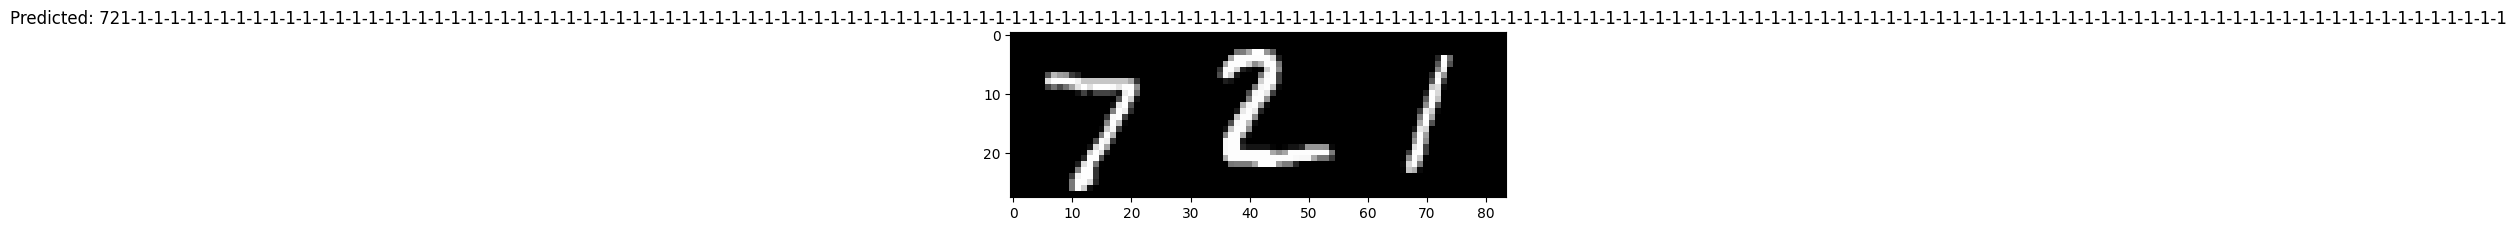

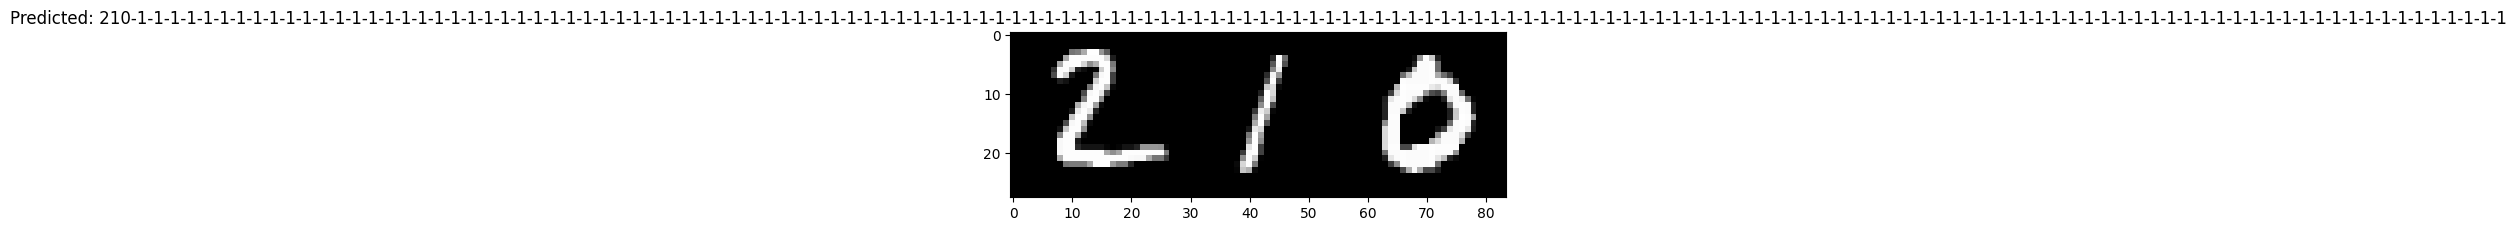

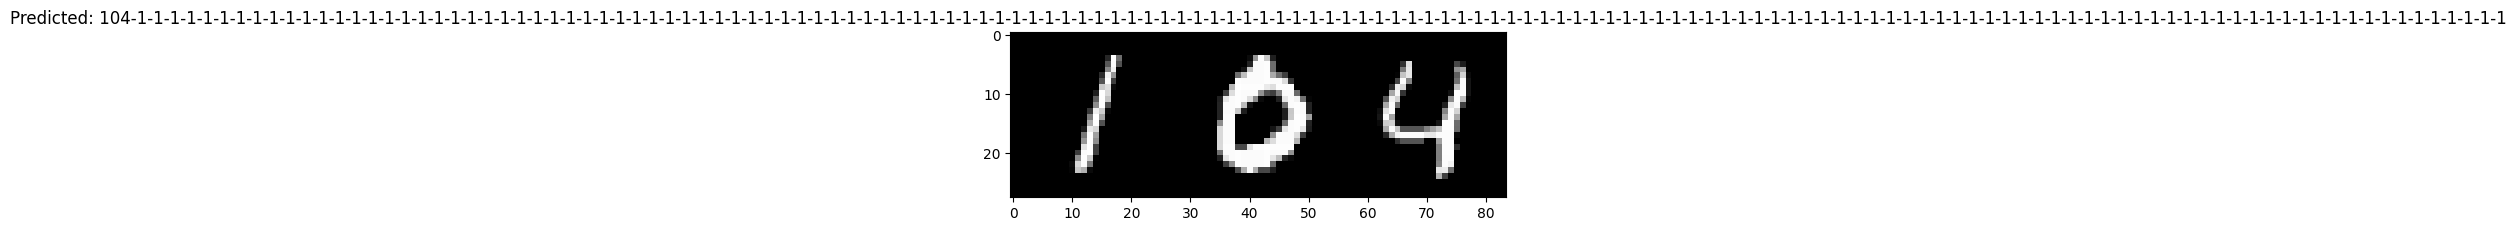

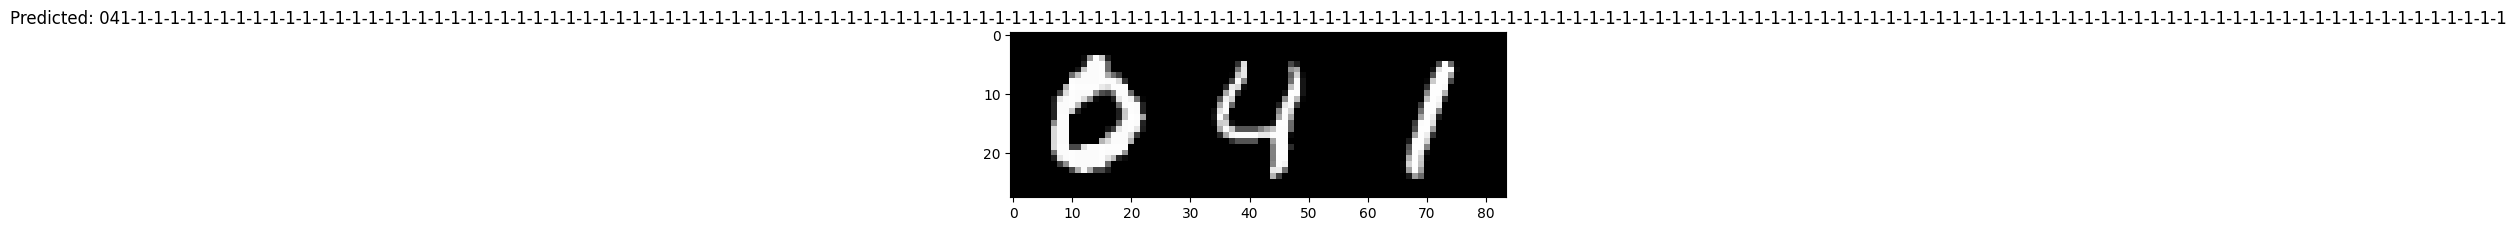

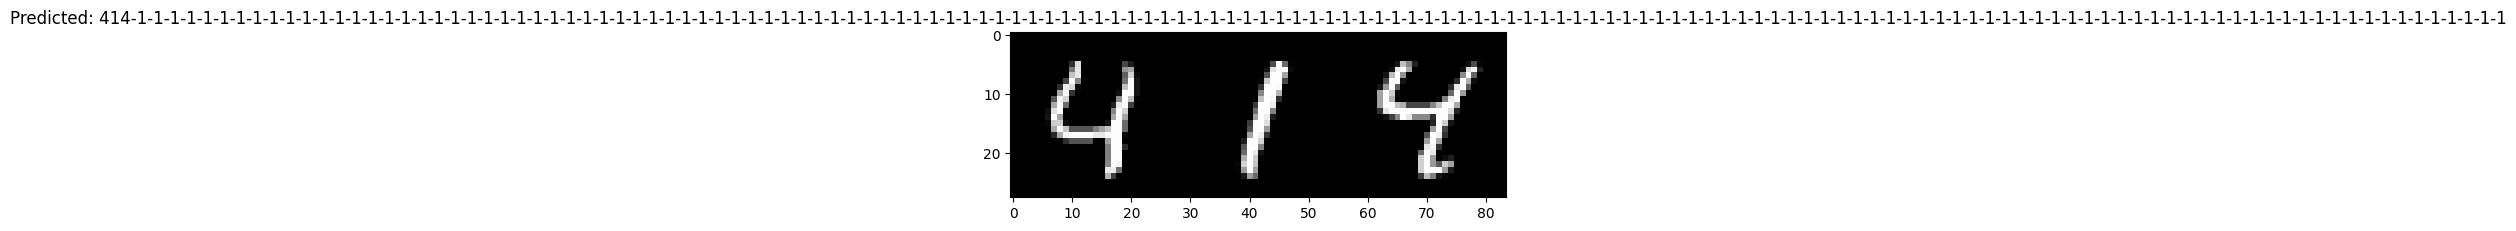

In [1]:
# Step 1: Set up Google Colab environment
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Dense, LSTM, Bidirectional, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Load and Prepare the MNIST Dataset
def load_multi_digit_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0

    num_digits = 3
    x_train_multi, y_train_multi = [], []
    for i in range(len(x_train) - num_digits):
        stacked_images = np.hstack(x_train[i:i+num_digits])
        stacked_images = np.expand_dims(stacked_images, axis=-1)
        x_train_multi.append(stacked_images)
        stacked_labels = np.array([y_train[i], y_train[i+1], y_train[i+2]])
        y_train_multi.append(stacked_labels)

    x_train_multi = np.array(x_train_multi)
    y_train_multi = np.array(y_train_multi)

    x_test_multi, y_test_multi = [], []
    for i in range(len(x_test) - num_digits):
        stacked_images = np.hstack(x_test[i:i+num_digits])
        stacked_images = np.expand_dims(stacked_images, axis=-1)
        x_test_multi.append(stacked_images)
        stacked_labels = np.array([y_test[i], y_test[i+1], y_test[i+2]])
        y_test_multi.append(stacked_labels)

    x_test_multi = np.array(x_test_multi)
    y_test_multi = np.array(y_test_multi)

    return x_train_multi, y_train_multi, x_test_multi, y_test_multi

x_train, y_train, x_test, y_test = load_multi_digit_mnist()

# Step 3: Define the CTC Loss Function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Step 4: Build the CRNN Model
def build_crnn_model(input_shape=(28, 28*3, 1), num_classes=10):
    input_data = Input(name="input", shape=input_shape)
    cnn = Conv2D(32, (3, 3), activation="relu", padding="same")(input_data)
    cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
    cnn = Conv2D(64, (3, 3), activation="relu", padding="same")(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2))(cnn)

    reshaped_units = cnn.shape[1] * cnn.shape[2]
    cnn = Reshape(target_shape=(reshaped_units, cnn.shape[-1]))(cnn)

    lstm = Bidirectional(LSTM(128, return_sequences=True))(cnn)
    lstm = Bidirectional(LSTM(128, return_sequences=True))(lstm)
    dense = Dense(num_classes + 1, activation="softmax")(lstm)  # +1 for CTC blank label

    labels = Input(name="labels", shape=[None], dtype="float32")
    input_length = Input(name="input_length", shape=[1], dtype="int64")
    label_length = Input(name="label_length", shape=[1], dtype="int64")
    ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [dense, labels, input_length, label_length]
    )

    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)
    model.compile(optimizer=Adam(), loss={"ctc": lambda y_true, y_pred: y_pred})
    prediction_model = Model(inputs=input_data, outputs=dense)

    return model, prediction_model

model, prediction_model = build_crnn_model()
print("Model built successfully!")

# Step 5: Define Data Augmentation with Additional CTC Inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

class CTCAugmentedDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=64, num_classes=10):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.datagen = ImageDataGenerator(rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        augmented_images = next(self.datagen.flow(batch_x, batch_size=self.batch_size, shuffle=False))
        input_length = np.ones((self.batch_size, 1)) * (augmented_images.shape[1] // 2)
        label_length = np.ones((self.batch_size, 1)) * 3

        batch_y = np.array(batch_y)
        ctc_dummy_output = np.zeros(self.batch_size)
        # Convert outputs to tf.Tensor format for compatibility
        return (  # Changed from [ to ( to return a tuple
            (tf.convert_to_tensor(augmented_images, dtype=tf.float32),
             tf.convert_to_tensor(batch_y, dtype=tf.float32),
             tf.convert_to_tensor(input_length, dtype=tf.float32),
             tf.convert_to_tensor(label_length, dtype=tf.float32)),
            tf.convert_to_tensor(ctc_dummy_output, dtype=tf.float32)
        ) # Changed from ] to ) to return a tuple

batch_size = 32
train_gen = CTCAugmentedDataGenerator(x_train, y_train, batch_size=batch_size)

# Step 6: Train the Model
epochs = 8
input_length_test = np.ones((len(x_test), 1)) * (x_test.shape[2] // 4)
label_length_test = np.ones((len(y_test), 1)) * 3

# Ensure all inputs are converted to tf.Tensor format
x_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)
input_length_test_tensor = tf.convert_to_tensor(input_length_test, dtype=tf.float32)
label_length_test_tensor = tf.convert_to_tensor(label_length_test, dtype=tf.float32)

model.fit(
    train_gen,
    epochs=epochs,
    validation_data=(
        [x_test_tensor, y_test_tensor, input_length_test_tensor, label_length_test_tensor],
        tf.convert_to_tensor(np.zeros(len(x_test)), dtype=tf.float32),
    ),
)

# Step 7: Evaluate and Predict
def decode_predictions(preds):
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    decoded = tf.keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)[0][0]
    return tf.keras.backend.get_value(decoded)

test_preds = prediction_model.predict(x_test)
decoded_preds = decode_predictions(test_preds)

for i in range(5):
    plt.imshow(x_test[i].reshape(28, 28 * 3), cmap="gray")
    plt.title(f"Predicted: {''.join(map(str, decoded_preds[i]))}")
    plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


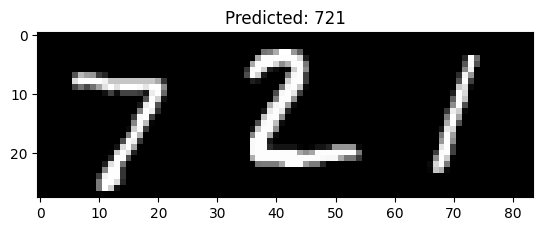

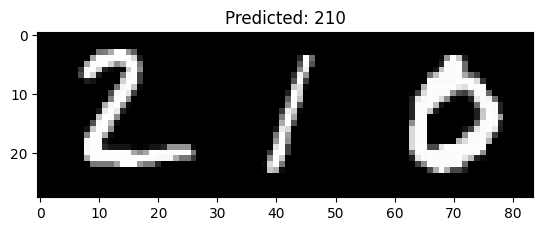

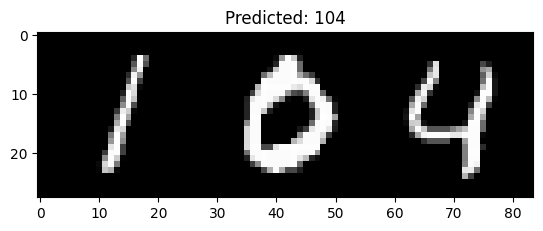

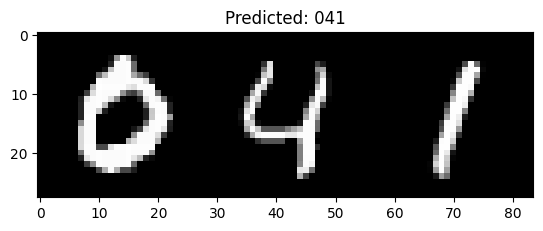

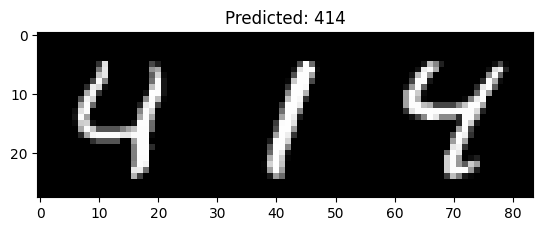

In [2]:
def decode_predictions(preds):
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    decoded = tf.keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)[0][0]
    decoded = tf.keras.backend.get_value(decoded)

    # Remove duplicates and blanks (-1) from decoded output
    cleaned_predictions = []
    for sequence in decoded:
        cleaned_sequence = [digit for i, digit in enumerate(sequence) if digit != -1 and (i == 0 or digit != sequence[i - 1])]
        cleaned_predictions.append(cleaned_sequence)

    return cleaned_predictions

# Testing the updated decode_predictions function
test_preds = prediction_model.predict(x_test)
decoded_preds = decode_predictions(test_preds)

for i in range(5):
    plt.imshow(x_test[i].reshape(28, 28 * 3), cmap="gray")
    plt.title(f"Predicted: {''.join(map(str, decoded_preds[i]))}")
    plt.show()
